## Using the Bellman Ford Algrithm to Detect Arbitrages

Note:- We are only using the 5 tokens present on all 5 exchanges for simplicity. they are:

* Bitcoin Cash
* Bitcoin
* Ethereum
* Litecoin
* Ripple

In [1]:
import pandas as pd
import networkx as nx
from networkx import NetworkXUnbounded 
import matplotlib.pyplot as plt
import math

In [2]:
data = pd.read_csv("Table.csv")
ADA_binance = pd.read_csv("ADA_binance.csv")

In [3]:
data.drop('Unnamed: 0', axis = 'columns', inplace = True)
ADA_binance = ADA_binance[:44641]
data.set_index(ADA_binance['timestamp'], inplace = True)
data.columns = ['binance_bch', 'bitstamp_bch', 'bittrex_bch', 'ftx_bch', 'kucoin_bch', 'binance_btc',
                'bitstamp_btc', 'bittrex_btc', 'ftx_btc', 'kucoin_btc', 'binance_eth',
                'bitstamp_eth', 'bittrex_eth', 'ftx_eth', 'kucoin_eth', 'binance_ltc',
                'bitstamp_ltc', 'bittrex_ltc', 'ftx_ltc', 'kucoin_ltc', 'binance_xrp',
                'bitstamp_xrp', 'bittrex_xrp', 'ftx_xrp', 'kucoin_xrp']
data

binance_bch  bitstamp_bch  bittrex_bch  ftx_bch  \
timestamp                                                              
2021-05-01 00:00:00       996.98        996.10   996.901359   996.14   
2021-05-01 00:01:00       994.23       1000.14   996.901359   994.07   
2021-05-01 00:02:00       999.98        998.23   996.901359   999.45   
2021-05-01 00:03:00       998.59       1000.88   996.901359   999.03   
2021-05-01 00:04:00      1001.00       1004.61  1000.659641  1000.44   
...                          ...           ...          ...      ...   
2021-05-31 23:56:00       702.68        702.60   702.074226   701.70   
2021-05-31 23:57:00       702.58        702.32   702.190198   702.25   
2021-05-31 23:58:00       703.40        703.66   702.190198   702.80   
2021-05-31 23:59:00       702.46        699.93   703.354928   702.30   
2021-06-01 00:00:00       699.27        703.19   701.016827   699.39   

                     kucoin_bch  binance_btc  bitstamp_btc   bittrex_btc  \
timestamp                                                                  
2021-05-01 00:00:00      996.14     57545.06      57633.91  57546.489750   
2021-05-01 00:01:00      994.07     57542.62      57784.81  57511.424451   
2021-05-01 00:02:00      999.45     57703.10      57793.39  57700.123176   
2021-05-01 00:03:00      999.03     57710.26      57864.17  57734.096140   
2021-05-01 00:04:00     1000.44     57777.03      57878.68  57757.572149   
...                         ...          ...           ...           ...   
2021-05-31 23:56:00      701.70     37284.49      37319.84  37276.506831   
2021-05-31 23:57:00      702.25     37289.67      37320.79  37302.195920   
2021-05-31 23:58:00      702.80     37307.15      37341.41  37314.560397   
2021-05-31 23:59:00      702.30     37253.81      37130.45  37257.634788   
2021-06-01 00:00:00      699.39     37124.60      37231.81  37135.517498   

                     ftx_btc  kucoin_btc  ...  binance_ltc  bitstamp_ltc  \
timestamp                                 ...                              
2021-05-01 00:00:00  57551.5     57551.5  ...       270.97        271.16   
2021-05-01 00:01:00  57542.7     57542.7  ...       270.78        272.72   
2021-05-01 00:02:00  57699.9     57699.9  ...       272.67        272.25   
2021-05-01 00:03:00  57720.1     57720.1  ...       271.79        272.66   
2021-05-01 00:04:00  57771.5     57771.5  ...       271.94        272.27   
...                      ...         ...  ...          ...           ...   
2021-05-31 23:56:00  37283.1     37283.1  ...       187.44        187.83   
2021-05-31 23:57:00  37294.5     37294.5  ...       187.60        187.97   
2021-05-31 23:58:00  37302.6     37302.6  ...       187.99        188.31   
2021-05-31 23:59:00  37257.6     37257.6  ...       187.97        187.28   
2021-06-01 00:00:00  37130.1     37130.1  ...       187.18        187.78   

                     bittrex_ltc  ftx_ltc  kucoin_ltc  binance_xrp  \
timestamp                                                            
2021-05-01 00:00:00   271.260572  271.130     271.130       1.5945   
2021-05-01 00:01:00   270.951216  270.635     270.635       1.6000   
2021-05-01 00:02:00   270.951216  272.351     272.351       1.6160   
2021-05-01 00:03:00   270.951216  271.780     271.780       1.6223   
2021-05-01 00:04:00   270.951216  271.928     271.928       1.6149   
...                          ...      ...         ...          ...   
2021-05-31 23:56:00   187.813981  187.500     187.500       1.0400   
2021-05-31 23:57:00   187.650891  187.607     187.607       1.0424   
2021-05-31 23:58:00   187.908793  187.958     187.958       1.0456   
2021-05-31 23:59:00   187.908793  188.142     188.142       1.0409   
2021-06-01 00:00:00   187.782564  187.081     187.081       1.0323   

                     bitstamp_xrp  bittrex_xrp  ftx_xrp  kucoin_xrp  
timestamp                                                            
2021-05-01 00:00:00       1.59759     1.595159  1.59414

In [4]:
#Creating the graph and a temporary graph
G = nx.DiGraph()
nodes = data.columns
for node in nodes:
    G.add_node(node)
#Adding the nodes to G

T = nx.complete_graph(25)
nodes = data.columns
mapping = dict(list(enumerate(nodes)))
T = nx.relabel_nodes(T, mapping)

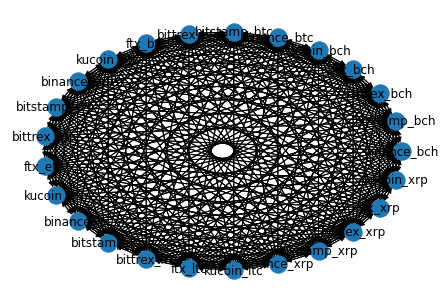

In [5]:
#Adding the edges to G

for e in T.edges():
    G.add_edge(e[0], e[1])
    G.add_edge(e[1], e[0])
    
nx.draw_circular(G, with_labels = True)    

In [6]:
len(nx.edges(G))

600

In [7]:
#Function to initialize the network using data from that instant of time
def graph_init(g, t):
    for e in g.edges():
        conversion = (data[e[1]][t])/(data[e[0]][t])
        g[e[0]][e[1]]['weight'] = math.log(conversion, 10)
    return g

In [8]:
#Function to check for negatie weight cycles using BFA
def negcyc_check1(g, source):
    
    for e in T.edges():
        T[e[0]][e[1]]['weight'] = 0
    #Initializing the temp graph to zero    
    dist = {}
    keys = list(data.columns)
    for i in keys:
        dist[i] = 1000000  
    dist[source] = 0
    
    for i in range(1, g.number_of_nodes()):
        for e in g.edges():
            weight = g[e[0]][e[1]]['weight']
            if (dist[e[0]] != 1000000 and dist[e[0]] + weight < dist[e[1]]):
                dist[e[1]] = dist[e[0]] + weight;
                
    for i in range(g.number_of_edges()):
        weight = g[e[0]][e[1]]['weight']
        if (dist[e[0]] != 1000000 and dist[e[0]] + weight < dist[e[1]]):
            return True;
    
    return False             

In [9]:
#Function to check for negatie weight cycles using BFA
def negcyc_check2(g, source):
    
    for e in T.edges():
        T[e[0]][e[1]]['weight'] = 0
    #Initializing the temp graph to zero    
    dist = {}
    predecessor = {}
    keys = list(data.columns)
    for i in keys:
        dist[i] = 1000000  
        predecessor[i] = 0
    dist[source] = 0
    
    for i in range(1, g.number_of_nodes()):
        for e in g.edges():
            weight = g[e[0]][e[1]]['weight']
            if (dist[e[0]] != 1000000 and dist[e[0]] + weight < dist[e[1]]):
                dist[e[1]] = dist[e[0]] + weight
                predecessor[e[1]] = e[0]
                
    for e in g.edges():
        weight = g[e[0]][e[1]]['weight']
        if (dist[e[0]] != 1000000 and dist[e[0]] + weight < dist[e[1]]):
            print("Graph has a Negative-Weight Cycle")
            return
    
    print(dist)
    print(predecessor)
    return          

In [10]:
for t in range(1, 11):
    graph_init(G, t)
    for i in G.nodes():
        print(negcyc_check2(G, i))

Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weig

Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weight Cycle
None
Graph has a Negative-Weig

### Testing it for Binance

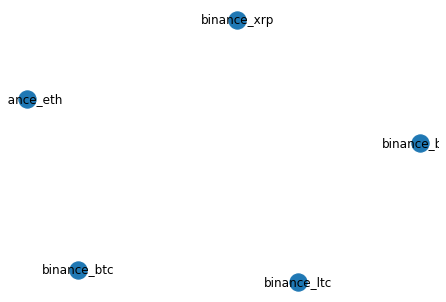

In [11]:
binance = nx.DiGraph()
nodes = ['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc', 'binance_xrp']
# mapping = dict(list(enumerate(nodes)))
# binance = nx.relabel_nodes(binance, mapping)
for node in nodes:
    binance.add_node(node)
nx.draw(binance, with_labels = True)    

In [12]:
binance_edges = [('binance_bch', 'binance_btc'), ('binance_btc', 'binance_bch'),
                 ('binance_bch', 'binance_eth'), ('binance_eth', 'binance_bch'),
                 ('binance_bch', 'binance_ltc'), ('binance_ltc', 'binance_bch'),
                 ('binance_bch', 'binance_xrp'), ('binance_xrp', 'binance_bch'),
                 ('binance_btc', 'binance_eth'), ('binance_eth', 'binance_btc'),
                 ( 'binance_btc', 'binance_ltc'), ('binance_ltc', 'binance_btc'),
                 ('binance_btc', 'binance_xrp'), ('binance_xrp', 'binance_btc'),
                 ('binance_eth', 'binance_ltc'), ('binance_ltc', 'binance_eth'),
                 ('binance_eth', 'binance_xrp'), ('binance_xrp', 'binance_eth'),
                 ('binance_ltc', 'binance_xrp'), ('binance_xrp', 'binance_ltc')]
binance.add_edges_from(binance_edges)

In [13]:
graph_init(binance, 1)

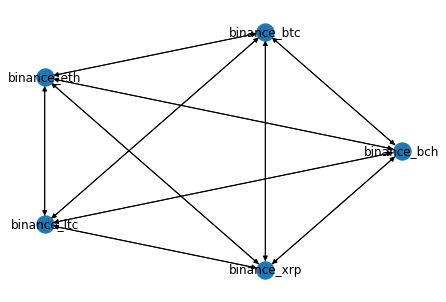

In [14]:
nx.draw_circular(binance, with_labels = True)

{('binance_bch',
  'binance_btc'): Text(0.654508480212244, 0.4755283023511464, '1.76'),
 ('binance_bch',
  'binance_eth'): Text(0.09549145273252935, 0.2938926212887637, '0.44'),
 ('binance_bch',
  'binance_ltc'): Text(0.09549151233717518, -0.2938926630120157, '-0.56'),
 ('binance_bch',
  'binance_xrp'): Text(0.6545085547180512, -0.4755282248651067, '-2.79'),
 ('binance_btc',
  'binance_bch'): Text(0.654508480212244, 0.4755283023511464, '-1.76'),
 ('binance_btc',
  'binance_eth'): Text(-0.2500000670552266, 0.7694208997980517, '-1.32'),
 ('binance_btc',
  'binance_ltc'): Text(-0.2500000074505807, 0.1816356154972723, '-2.33'),
 ('binance_btc',
  'binance_xrp'): Text(0.30901703493029536, 5.3644181319256745e-08, '-4.56'),
 ('binance_eth',
  'binance_bch'): Text(0.09549145273252935, 0.2938926212887637, '-0.44'),
 ('binance_eth',
  'binance_btc'): Text(-0.2500000670552266, 0.7694208997980517, '1.32'),
 ('binance_eth',
  'binance_ltc'): Text(-0.8090170349302954, -6.55651103964594e-08, '-1.01')

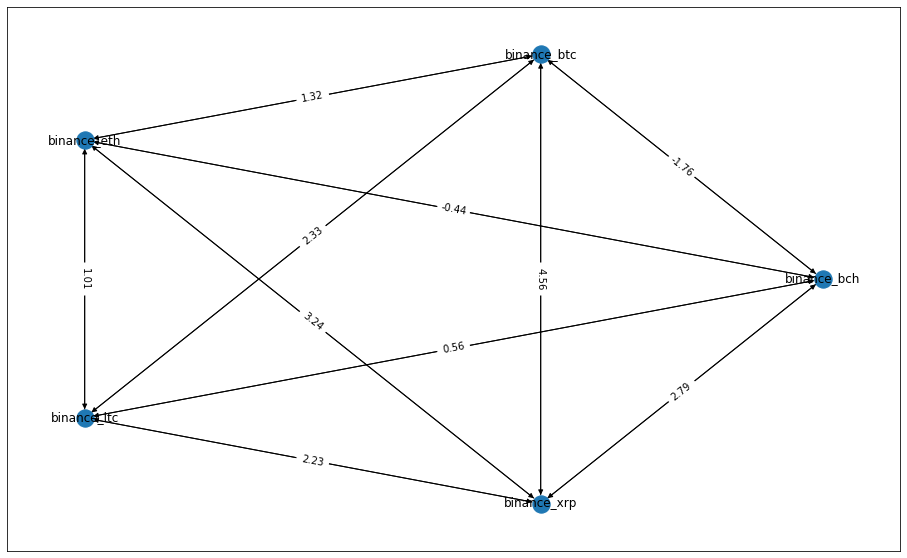

In [15]:
f,ax = plt.subplots(1,1, figsize = (16,10))
pos = nx.circular_layout(binance) 
nx.draw_networkx(binance, pos)
labels = nx.get_edge_attributes(binance, 'weight')
for dict_value in labels:
        labels[dict_value] = round(labels[dict_value], 2)
nx.draw_networkx_edge_labels(binance, pos , edge_labels = labels, ax = ax)

In [16]:
pred, dist = nx.single_source_bellman_ford(binance, 'binance_bch', weight = 'weight')
print(pred)
print(dist)

{'binance_bch': 0, 'binance_btc': 1.7625027686222816, 'binance_eth': 0.4445631020757048, 'binance_ltc': -0.5648702795440192, 'binance_xrp': -2.7933668807918837}
{'binance_bch': ['binance_bch'], 'binance_btc': ['binance_bch', 'binance_btc'], 'binance_eth': ['binance_bch', 'binance_eth'], 'binance_ltc': ['binance_bch', 'binance_ltc'], 'binance_xrp': ['binance_bch', 'binance_xrp']}


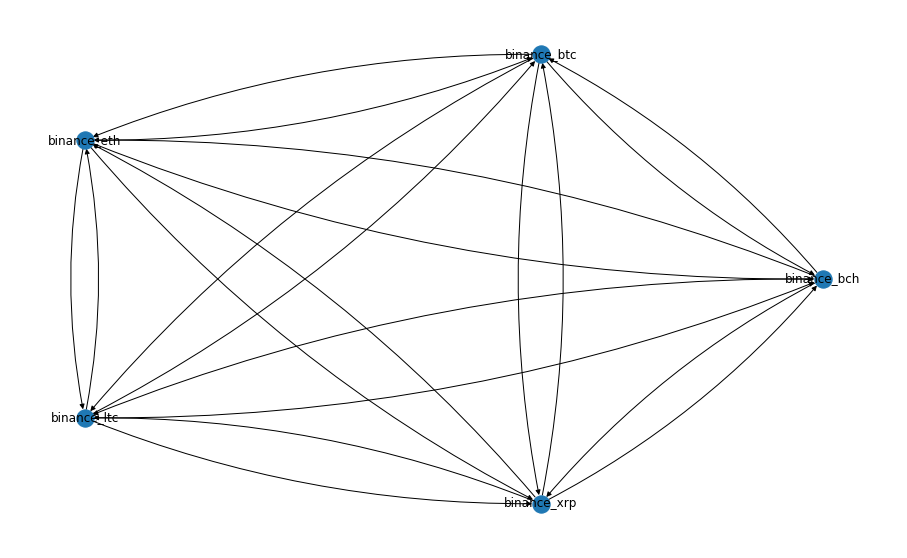

In [18]:
f,ax = plt.subplots(1,1, figsize = (16,10))
pos = nx.circular_layout(binance) 
#nx.draw_networkx(binance, pos)
labels = nx.get_edge_attributes(binance, 'weight')
for dict_value in labels:
        labels[dict_value] = round(labels[dict_value], 2)
# nx.draw_networkx_edge_labels(binance, pos , edge_labels = labels, ax = ax)
nx.draw(binance, pos, with_labels = True, connectionstyle='arc3, rad = 0.1')

### Function to print the negative-weight cycle

In [34]:
def find_path(digraph):
    count = 0
    cycles = nx.simple_cycles(digraph) 
    for cycle in cycles:
        weight = 0
        for i in range(0, len(cycle)):
            if(i == len(cycle)-1):
                weight = weight + G[cycle[i]][cycle[0]]['weight']
            else:    
                weight = weight + G[cycle[i]][cycle[i+1]]['weight']
        if(weight!=0):
            count = count + 1
            print(cycle, 10**(weight))    
    return (count)   

In [35]:
count = []
profit = []
for t in range(1, 441):
    graph_init(binance, t)
    find_path(binance)
    count.append(find_path(binance))
#     if(profit > 1):
#         count.append()

['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc', 'binance_eth'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.000000000000000

['binance_bch', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_ltc'] 0.9999999999999998
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000016
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_bch', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999984
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_eth', 'binance_bt

['binance_bch', 'binance_ltc', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_ltc', 'binance_eth'] 0.9999999999999997
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.9999999999999983
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_ltc'] 0.9999999999999998
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000016
['binance_bch', 'binance_et

['binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_ltc', 'binance_xrp', 'binance_btc'] 1.000000000000001
['binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bc

['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc', 'binance_xrp'] 1

['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc', 'binance_eth'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.000000000000001
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993

['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc', 'binance_eth'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.000000000000001
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993

['binance_bch', 'binance_eth', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000016
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_bch', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999984
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.99999999999999

['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc', 'binance_eth'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.000000000000001
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc

['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc', 'binance_eth'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.000000000000000

['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000016
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_bch', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999984
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.99999999999999

['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.00000000000000

['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc', 'binance_eth'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.000000000000001
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.000000000000000

['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1

['binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_ltc', 'binance_xrp', 'binance_btc'] 1.000000000000001
['binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bc

['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc', 'binance_eth'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.000000000000000

['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1

['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc', 'binance_xrp'] 1

['binance_bch', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_ltc', 'binance_eth'] 0.9999999999999997
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.9999999999999983
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.999999999999999

['binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_ltc', 'binance_xrp', 'binance_btc'] 1.000000000000001
['binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bc

['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc', 'binance_eth'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.000000000000001
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993

['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.000000000000001
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_ltc', 'binance_eth'] 0.999999999999999

['binance_eth', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_ltc', 'binance_xrp', 'binance_btc'] 1.000000000000001
['binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_b

['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.000000000000001
['binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc', 'binance_xrp'] 0.999999999999999
['binance_et

['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_ltc', 'binance_eth'] 0.9999999999999997
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.9999999999999983
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_ltc'] 0.9999999999999998
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xr

['binance_eth', 'binance_btc', 'binance_ltc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_ltc', 'binance_xrp', 'binance_btc'] 1.000000000000001
['binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth',

['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.000000000000001
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_ltc', 'binance_eth'] 0.999999999999999

['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_ltc', 'binance_eth'] 0.9999999999999997
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.9999999999999983
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_ltc'] 0.9999999999999998
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000016
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_bch', 'binance_eth', 'binance_xr

['binance_bch', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_ltc'] 0.9999999999999998
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000016
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_bch', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999984
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_lt

['binance_bch', 'binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999984
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp', 

['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc', 'binance_eth'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.000000000000001
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.000000000000000

['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.000000000000001
['binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_ltc', 'binance_xrp', 'binance_btc'] 1.000000000000001
['binance_ltc', 'binance_btc', 'binance_xrp'] 0.99999999

['binance_bch', 'binance_ltc'] 0.9999999999999998
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000016
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_bch', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999984
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_bt

['binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_ltc', 'binance_xrp', 'binance_btc'] 1.000000000000001
['binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999

['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc', 'binance_xrp'] 1

['binance_bch', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc'] 1

['binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_ltc', 'binance_xrp', 'binance_btc'] 1.000000000000001
['binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc', 'binance_ltc']

['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc', 'binance_eth'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.000000000000001
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_eth', 'b

['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1

['binance_bch', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999984
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_eth'] 0.99999999999999

['binance_bch', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_ltc'] 0.9999999999999998
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000016
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_bch', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999984
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_lt

['binance_bch', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc', 'binance_eth'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.000000000000001
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch'

['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.000000000000001
['binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_ltc', 'binance_x

['binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_ltc', 'binance_xrp', 'binance_btc'] 1.000000000000001
['binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_xr

['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_ltc', 'binance_eth'] 0.9999999999999997
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.9999999999999983
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_ltc'] 0.9999999999999998
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000016
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_bch', 'binance_eth', 'binance_xr

['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999984
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp'] 

['binance_eth', 'binance_btc', 'binance_ltc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_ltc', 'binance_xrp', 'binance_btc'] 1.000000000000001
['binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth',

['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc', 'binance_eth'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.000000000000000

['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.000000000000001
['binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc

['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_ltc', 'binance_eth'] 0.9999999999999997
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.9999999999999983
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_ltc'] 0.9999999999999998
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_et

['binance_bch', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc', 'binance_eth'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.000000000000001
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch'

['binance_bch', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_bch', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999984
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.99999999999999

['binance_bch', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_ltc'] 0.9999999999999998
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000016
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_bch', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999984
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_lt

['binance_bch', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_ltc'] 0.9999999999999998
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000016
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_bch', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999984
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_eth', 'binance_bt

['binance_bch', 'binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999984
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp', 

['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc', 'binance_eth'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.000000000000001
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc

['binance_eth', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_ltc', 'binance_xrp', 'binance_btc'] 1.000000000000001
['binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_b

['binance_bch', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc'] 1

['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999984
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp'] 

['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc', 'binance_eth'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.000000000000001
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc

['binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_ltc', 'binance_xrp', 'binance_btc'] 1.000000000000001
['binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bc

['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc', 'binance_eth'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.000000000000001
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_eth', 'b

['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.000000000000001
['binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_ltc', 'binance_xrp', 'binance_btc'] 1.000000000000001
['binance_ltc', 'binance_btc', 'binance_xrp'] 0.99999999

['binance_bch', 'binance_btc', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.000000000000001
['binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_ltc'

['binance_bch', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth'] 1.00000000000000

['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_ltc', 'binance_eth'] 0.9999999999999997
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.9999999999999983
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_ltc'] 0.9999999999999998
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xr

['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc', 'binance_eth'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.000000000000001
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993

['binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc', 'binance_eth'] 1.0000000000000004
['binance_bch'

['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc', 'binance_eth'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.000000000000001
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.000000000000000

['binance_bch', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc'] 1

['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_ltc', 'binance_eth'] 0.9999999999999997
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.9999999999999983
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_ltc'] 0.9999999999999998
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_et

['binance_bch', 'binance_ltc', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_ltc', 'binance_eth'] 0.9999999999999997
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.9999999999999983
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_ltc'] 0.9999999999999998
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000016
['binance_bch', 'binance_et

['binance_bch', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc'] 1

['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.000000000000001
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_ltc', 'binance_eth'] 0.9999999999999997
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.

['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.000000000000001
['binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999

['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.000000000000001
['binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999

['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.00000000000000

['binance_bch', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth'] 1.00000000000000

['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000016
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_bch', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999984
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.99999999999999

['binance_ltc', 'binance_xrp', 'binance_btc'] 1.000000000000001
['binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_btc',

['binance_eth', 'binance_btc', 'binance_ltc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_ltc', 'binance_xrp', 'binance_btc'] 1.000000000000001
['binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth',

['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.000000000000001
['binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc', 'binance_xrp'] 0.999999999999999
['binance_et

['binance_bch', 'binance_ltc'] 0.9999999999999998
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000016
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_bch', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999984
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_bt

['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.000000000000001
['binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc', 'binance_xrp'] 0.999999999999999
['binance_et

['binance_bch', 'binance_btc', 'binance_ltc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.000000000000001
['binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'

['binance_bch', 'binance_btc', 'binance_ltc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.000000000000001
['binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'

['binance_bch', 'binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999984
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_btc', 'binance_ltc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp', 

['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc', 'binance_eth'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.000000000000001
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993

['binance_bch', 'binance_btc', 'binance_eth'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.000000000000001
['binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_ltc', 'binance_xrp', 'binance_btc'] 1.000000000000001
['binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth', 'binance_bt

['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_ltc', 'binance_eth'] 0.9999999999999997
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.9999999999999983
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_ltc'] 0.9999999999999998
['binance_bch', 'binance_eth', 'binance_xr

['binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_ltc', 'binance_xrp', 'binance_btc'] 1.000000000000001
['binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth']

['binance_bch', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc', 'binance_eth'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.000000000000001
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch'

['binance_bch', 'binance_ltc'] 0.9999999999999998
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000016
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_bch', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999984
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_bt

['binance_bch', 'binance_btc', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_btc', 'binance_eth'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.000000000000001
['binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc', 'binance_xrp'] 0.999999999999999
['binance_et

['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc', 'binance_eth'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.000000000000001
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc

['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc', 'binance_eth'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.000000000000001
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.000000000000000

['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.000000000000001
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_ltc', 'binance_eth'] 0.9999999999999997
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.

['binance_bch', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_ltc'] 0.9999999999999998
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000016
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_bch', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999984
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_eth', 'binance_bt

['binance_bch', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc', 'binance_eth'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.000000000000001
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch'

['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc', 'binance_eth'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.000000000000001
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.000000000000000

['binance_eth', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_ltc', 'binance_xrp', 'binance_btc'] 1.000000000000001
['binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_b

['binance_ltc', 'binance_xrp', 'binance_btc'] 1.000000000000001
['binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_btc',

['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc', 'binance_eth'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth', 'binance_ltc'] 1.000000000000001
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009

['binance_bch', 'binance_btc', 'binance_eth'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.000000000000001
['binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_eth', 'binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc', 'binance_xrp'] 0.999999999999999
['binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_ltc', 'binance_xrp', 'binance_btc'] 1.000000000000001
['binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth', 'binance_bt

['binance_bch', 'binance_ltc'] 0.9999999999999998
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000016
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_bch', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999984
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_bt

['binance_bch', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_btc', 'binance_eth'] 1.0000000000000009
['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_ltc', 'binance_eth'] 0.9999999999999997
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.9999999999999983
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_xrp'] 0.99999999999999

['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_ltc', 'binance_eth'] 0.9999999999999997
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.9999999999999983
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_ltc'] 0.9999999999999998
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xr

['binance_bch', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_ltc', 'binance_eth'] 0.9999999999999997
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_xrp', 'binance_eth'] 0.9999999999999983
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_ltc'] 0.9999999999999998
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xr

['binance_ltc', 'binance_xrp', 'binance_btc'] 1.000000000000001
['binance_ltc', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_btc',

['binance_bch', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_ltc'] 0.9999999999999998
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_ltc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.0000000000000016
['binance_bch', 'binance_eth', 'binance_xrp', 'binance_btc'] 1.0000000000000016
['binance_bch', 'binance_eth', 'binance_xrp'] 1.000000000000001
['binance_bch', 'binance_eth', 'binance_ltc', 'binance_xrp', 'binance_btc'] 1.0000000000000004
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp', 'binance_ltc'] 0.9999999999999984
['binance_bch', 'binance_eth', 'binance_btc', 'binance_xrp'] 0.999999999999999
['binance_bch', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_eth', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_btc', 'binance_xrp', 'binance_lt

['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc', 'binance_eth'] 0.9999999999999999
['binance_bch', 'binance_xrp', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc', 'binance_btc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_ltc'] 0.9999999999999994
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc', 'binance_ltc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth', 'binance_btc'] 0.999999999999999
['binance_bch', 'binance_xrp', 'binance_eth'] 0.9999999999999993
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc', 'binance_eth'] 1.0000000000000004
['binance_bch', 'binance_xrp', 'binance_btc', 'binance_ltc'] 1.000000000000000

In [33]:
df = pd.DataFrame(count)
df.mean()

0    0.0
dtype: float64

### Algorithm to find Triangles

In [21]:
def triangles(digraph):
    cycles = []
    temp = []
    for start in digraph.nodes():
        
        for node in digraph.nodes():
            if(node == start):
                continue
                
            for end in digraph.nodes():
                if(end == start or end == node):
                    continue
                
                temp = set([start, node, end])
                if(temp in cycles):
                    continue
                
                cycles.append(list(temp))    
    
    return((cycles))            

In [22]:
tri = triangles(G)
tri

[['bitstamp_bch', 'bittrex_bch', 'binance_bch'],
 ['ftx_bch', 'bitstamp_bch', 'binance_bch'],
 ['bitstamp_bch', 'kucoin_bch', 'binance_bch'],
 ['bitstamp_bch', 'binance_bch', 'binance_btc'],
 ['bitstamp_btc', 'bitstamp_bch', 'binance_bch'],
 ['bitstamp_bch', 'bittrex_btc', 'binance_bch'],
 ['bitstamp_bch', 'ftx_btc', 'binance_bch'],
 ['bitstamp_bch', 'binance_bch', 'kucoin_btc'],
 ['binance_eth', 'bitstamp_bch', 'binance_bch'],
 ['bitstamp_bch', 'bitstamp_eth', 'binance_bch'],
 ['bitstamp_bch', 'bittrex_eth', 'binance_bch'],
 ['bitstamp_bch', 'ftx_eth', 'binance_bch'],
 ['bitstamp_bch', 'kucoin_eth', 'binance_bch'],
 ['bitstamp_bch', 'binance_ltc', 'binance_bch'],
 ['bitstamp_bch', 'bitstamp_ltc', 'binance_bch'],
 ['bittrex_ltc', 'bitstamp_bch', 'binance_bch'],
 ['ftx_ltc', 'bitstamp_bch', 'binance_bch'],
 ['bitstamp_bch', 'kucoin_ltc', 'binance_bch'],
 ['bitstamp_bch', 'binance_bch', 'binance_xrp'],
 ['bitstamp_bch', 'bitstamp_xrp', 'binance_bch'],
 ['bittrex_xrp', 'bitstamp_bch', 'bi

In [23]:
count = 0
profit = []
for cycle in tri[:100]:
        weight = 0
        cell = 0
        for i in range(0, len(cycle)):
            if(i == len(cycle)-1):
                cell =  G[cycle[i]][cycle[0]]['weight']
                weight = weight + cell
                print(cell)
            else:    
                cell = G[cycle[i]][cycle[i+1]]['weight']
                weight = weight + cell
                print(cell)
#         if(weight>0.0000000000000000004):
#             count = count + 1
        profit.append(10**(weight))
        print(cycle, weight)    
# return (count)    

0.0001096736317596665
-0.00010537953232168563
-4.2940994379755216e-06
['bitstamp_bch', 'bittrex_bch', 'binance_bch'] 5.354942292541687e-18
0.0003823449947910234
4.294099437977791e-06
-0.0003866390942289723
['ftx_bch', 'bitstamp_bch', 'binance_bch'] 2.883977778811442e-17
-0.00038234499479100593
0.0003866390942289445
-4.2940994379755216e-06
['bitstamp_bch', 'kucoin_bch', 'binance_bch'] -3.6942494961549055e-17
4.294099437977791e-06
1.7582866916266588
-1.7582909857260969
['bitstamp_bch', 'binance_bch', 'binance_btc'] 0.0
-1.7588881169815491
4.294099437977791e-06
1.758883822882111
['bitstamp_btc', 'bitstamp_bch', 'binance_bch'] 0.0
1.7581433731740308
-1.758139079074593
-4.2940994379755216e-06
['bitstamp_bch', 'bittrex_btc', 'binance_bch'] -1.6840200837541647e-16
1.7582115659180593
-1.7582072718186212
-4.2940994379755216e-06
['bitstamp_bch', 'ftx_btc', 'binance_bch'] 5.364259654961484e-17
4.294099437977791e-06
1.7582072718186212
-1.7582115659180593
['bitstamp_bch', 'binance_bch', 'kucoin_btc

In [24]:
df = pd.DataFrame(profit)
df.describe()

0
count  1.000000e+02
mean   1.000000e+00
std    3.596668e-16
min    1.000000e+00
25%    1.000000e+00
50%    1.000000e+00
75%    1.000000e+00
max    1.000000e+00